In [1]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.io as sio
import seaborn as sns
import ancillary as ac
import matplotlib as mpl
import matplotlib.pyplot as plt
from nilearn import plotting
from PyPDF2 import PdfFileMerger
from natsort import natsorted
import statsmodels.api as sm
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.manova import MANOVA
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
def zscore(data, axis):
    data -= data.mean(axis=axis, keepdims=True)
    data /= data.std(axis=axis, keepdims=True)
    return np.nan_to_num(data, copy=False)

def correlation(matrix1, matrix2):
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]

    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2
    
    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)
    
    if matrix1.ndim >= matrix2.ndim:
        return np.dot(matrix1, matrix2.T)
    else:
        return np.dot(matrix2, matrix1.T)

In [3]:
ukb_smri_data_path = "/Users/xli77/Documents/MIVA/output/UKB_MMIVA_C30_preregSite_SMRI_MancovanOuts_wX_FINAL.mat"
ukb_smri_data = sio.loadmat(ukb_smri_data_path)['MODELUKB0s_ful']
ukb_smri_data_array = ukb_smri_data[0][0][0]
ukb_smri_data_key = np.squeeze(ukb_smri_data[0][0][3])
age_idx = np.where(ukb_smri_data_key==['age_when_attended_assessment_centre_f21003_2_0'])[0][0]
sex_idx = np.where(ukb_smri_data_key==['sex_f31_0_0'])[0][0]
age = ukb_smri_data_array[:, age_idx]
sex = ukb_smri_data_array[:, sex_idx]

In [4]:
datapath="/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/um2mm/"
subspace_struct_list=['234111','2222211','333111','441111','12x1']
num_subspace_struct=len(subspace_struct_list)

Y = np.zeros((num_subspace_struct,2,2,12,2907)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source
W = np.zeros((num_subspace_struct,2,2,12,44318)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source

num_iter=21
corr = np.zeros((num_subspace_struct,6,12,12))
# loss_um=np.zeros((num_subspace_struct,num_iter))
# loss_ummm=np.zeros((num_subspace_struct,num_iter))
# aux_um=np.zeros((num_subspace_struct,num_iter))
# aux_ummm=np.zeros((num_subspace_struct,num_iter))

for i,ss in enumerate(subspace_struct_list):

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_Y.mat"))
    Y1=np.squeeze(data['Y1'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_Y.mat"))
    Y2=np.squeeze(data['Y2'])

    Y[i,0,0]=Y1[0]
    Y[i,0,1]=Y1[1]
    Y[i,1,0]=Y2[0]
    Y[i,1,1]=Y2[1]

    for j in range(2):
        for k in range(2):
            for l in range(12):
                sgn = np.sign(correlation(Y[i,j,k,l],age))
                Y[i,j,k,l] = -sgn * Y[i,j,k,l]

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_W.mat"))
    W1=np.squeeze(data['W1'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_W.mat"))
    W2=np.squeeze(data['W2'])

    W[i,0,0]=W1[0]
    W[i,0,1]=W1[1]
    W[i,1,0]=W2[0]
    W[i,1,1]=W2[1]    

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","loss_um_neuroimaging_scoff.mat"))
    # loss_um[i]=np.squeeze(data['loss'])

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","loss_ummm_neuroimaging_scoff.mat"))
    # loss_ummm[i]=np.squeeze(data['loss'])

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging.mat"))
    # a = np.squeeze(data['aux_um'][1,:])
    # aux_um[i,:] = np.array([a[i][0][0] for i in range(num_iter)])

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging.mat"))
    # a = np.squeeze(data['aux_ummm'][1,:])
    # aux_ummm[i,:] = np.array([a[i][0][0] for i in range(num_iter)])

    corr[i,0] = np.corrcoef(Y1[0],Y1[0])[:12,:12]
    corr[i,1] = np.corrcoef(Y1[1],Y1[1])[:12,:12]
    corr[i,2] = np.corrcoef(Y1[0],Y1[1])[12:,:12]
    corr[i,3] = np.corrcoef(Y2[0],Y2[0])[:12,:12]
    corr[i,4] = np.corrcoef(Y2[1],Y2[1])[:12,:12]
    corr[i,5] = np.corrcoef(Y2[0],Y2[1])[12:,:12]

In [5]:
A = sio.loadmat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/A.mat")["A"]
A.shape

(4, 2, 2, 44318, 12)

In [6]:
WAY_list = []
cca_corr_list = []

for i in np.arange(0,10,2):
    # S1-4, UA/MSIVA, M1-2, voxel, source
    A1 = A[1,1,0,:,i:i+2] # structure 2, MSIVA, M1, subspace 1
    A2 = A[1,1,1,:,i:i+2] # structure 2, MSIVA, M2, subspace 1
    # Acat = np.concatenate((A1,A2), axis=1)

    Y1 = Y[1,1,0,i:i+2] 
    Y2 = Y[1,1,1,i:i+2] 
    # Ycat = np.concatenate((Y1,Y2), axis=0)

    AY1 = A1@Y1
    AY2 = A2@Y2

    # PCA AY1, AY2
    # AY1_p, AY1_p_projM = ac.base_PCA(AY1, num_PC=None, axis=-2, whitening=True)
    # AY2_p, AY2_p_projM = ac.base_PCA(AY2, num_PC=None, axis=-2, whitening=True)
    AY1_p, AY1_p_projM, AY1_p_projM_std = ac.base_PCA(AY1, num_PC=None, axis=-2, whitening=True)
    AY2_p, AY2_p_projM, AY2_p_projM_std = ac.base_PCA(AY2, num_PC=None, axis=-2, whitening=True)

    # turn off whitening, AY1_p = S @ Vt
    # SVt1, AY1_p_projM, AY1_p_projM_std = ac.base_PCA(AY1, num_PC=None, axis=-2, whitening=False)
    # SVt2, AY2_p_projM, AY2_p_projM_std = ac.base_PCA(AY2, num_PC=None, axis=-2, whitening=False)
    # use SVt for prediction

    # Post-PCA eigenvalue problem for CCA
    S12 = AY1_p @ AY2_p.T
    # Z1 = np.zeros(AY1_p.shape[0], dtype=AY1_p.dtype)
    # Z2 = np.zeros(AY2_p.shape[0], dtype=AY2_p.dtype)
    Z1 = np.zeros((AY1_p.shape[0],AY1_p.shape[0]), dtype=AY1_p.dtype)
    Z2 = np.zeros((AY2_p.shape[0],AY2_p.shape[0]), dtype=AY2_p.dtype)
    J = np.block([[Z1, S12],[S12.T, Z2]])
    U, S = ac.do_cov_EVD(J, k=2) # here, k = smallest subspace size in each modality

    # Final transformations: these multiply AY
    W1 = U[:2,].T @ AY1_p_projM
    W2 = U[2:,].T @ AY2_p_projM

    WAY1 = W1 @ AY1
    WAY2 = W2 @ AY2
    WAY_list.append( [WAY1, WAY2] )

    cca_corr = np.corrcoef(WAY1, WAY2)[2:,0:2]
    cca_corr_list.append(cca_corr)

# cca = CCA(n_components=2)
# cca.fit(AY1_p, AY2_p)
# WAY1_cca, WAY2_cca = cca.transform(AY1_p, AY2_p)

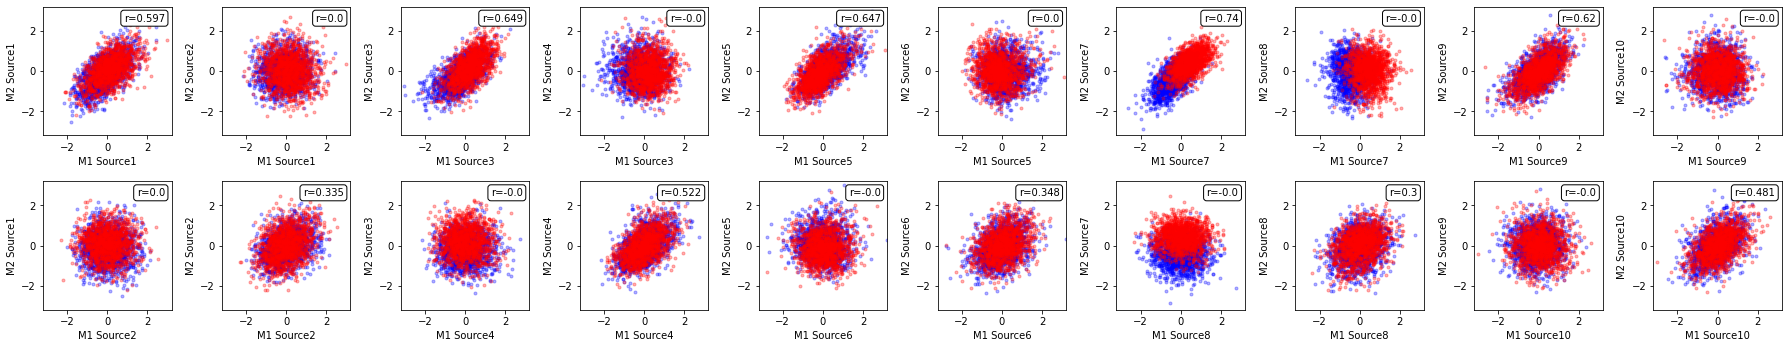

In [62]:
# CCA, color coded by age/sex
scv_list = []
for i in np.arange(0,10,2):
    scv_list.append([f"Source{i+1}", f"Source{i+2}"])

fig, axes = plt.subplots(2,10,figsize=(25,5))

for k in range(5):
    for i in range(2):
        for j in range(2):
            WAY1 = WAY_list[k][0]
            WAY2 = WAY_list[k][1]
            # print(i,j+2*k)
            # axes[i,j+2*k].plot(WAY1[i], WAY2[j],'.',alpha=0.3,label=f'r={round(cca_corr_list[k][i,j],3)}')
            axes[i,j+2*k].plot(WAY1[i][sex==0], WAY2[j][sex==0],'b.',alpha=0.3)
            axes[i,j+2*k].plot(WAY1[i][sex==1], WAY2[j][sex==1],'r.',alpha=0.3)
            axes[i,j+2*k].set_aspect('equal', 'box')
            # axes[i,j].set_title(f'r={round(cca_corr[i,j],3)}')
            axes[i,j+2*k].set_xlabel(f'M1 {scv_list[k][i]}')
            axes[i,j+2*k].set_ylabel(f'M2 {scv_list[k][j]}')
            axes[i,j+2*k].set_xlim([-3.2,3.2])
            axes[i,j+2*k].set_ylim([-3.2,3.2])
            axes[i,j+2*k].annotate(f'r={round(cca_corr_list[k][i,j],3)}', xy=(122, 122), xycoords='axes points',
                size=10, ha='right', va='top',
                bbox=dict(boxstyle='round', fc='w'))
            # axes[i,j].legend(handlelength=0)

plt.tight_layout()
# plt.savefig("cca_sex.pdf")
# plt.savefig("cca_sex.png", dpi=1000)

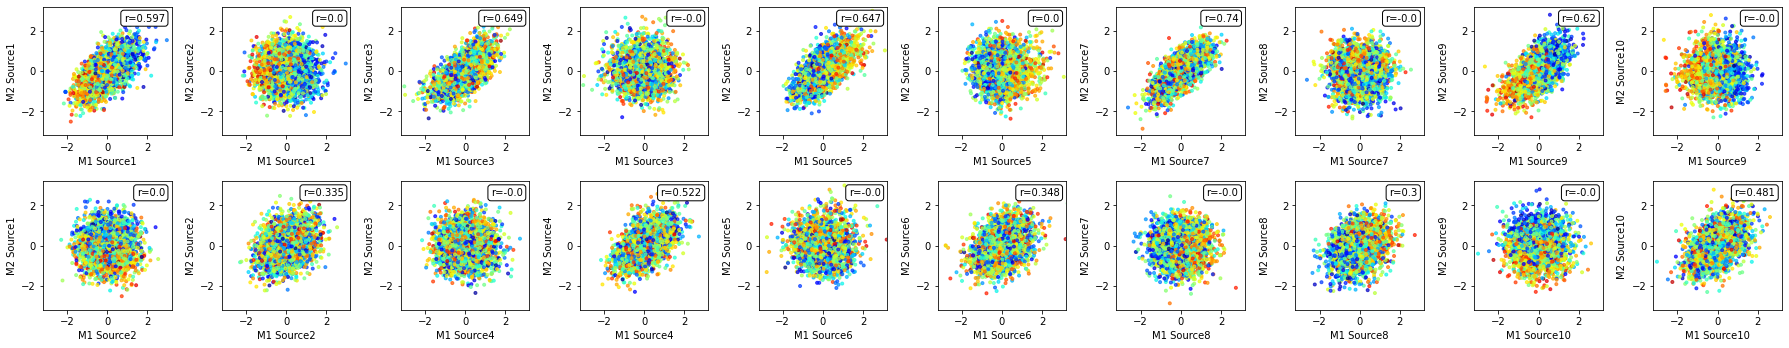

In [60]:
cols = plt.cm.jet(np.linspace(0,1,round(max(age)-min(age)+1)))

fig, axes = plt.subplots(2,10,figsize=(25,5))

for k in range(5):
    for i in range(2):
        for j in range(2):
            WAY1 = WAY_list[k][0]
            WAY2 = WAY_list[k][1]
            # print(i,j+2*k)
            
            col = np.zeros((len(age),4))
            for n in range(len(age)):
                colorind = round(age[n]-min(age))
                col[n] = cols[colorind]

            axes[i,j+2*k].scatter(WAY1[i], WAY2[j], color=col, marker='.', alpha=0.7)
            axes[i,j+2*k].set_aspect('equal', 'box')
            # axes[i,j].set_title(f'r={round(cca_corr[i,j],3)}')
            axes[i,j+2*k].set_xlabel(f'M1 {scv_list[k][i]}')
            axes[i,j+2*k].set_ylabel(f'M2 {scv_list[k][j]}')
            axes[i,j+2*k].set_xlim([-3.2,3.2])
            axes[i,j+2*k].set_ylim([-3.2,3.2])
            axes[i,j+2*k].annotate(f'r={round(cca_corr_list[k][i,j],3)}', xy=(122, 122), xycoords='axes points',
                size=10, ha='right', va='top',
                bbox=dict(boxstyle='round', fc='w'))
            # axes[i,j].legend(handlelength=0)

plt.tight_layout()
# plt.savefig("cca_age.pdf")
plt.savefig("cca_age.png", dpi=1000)

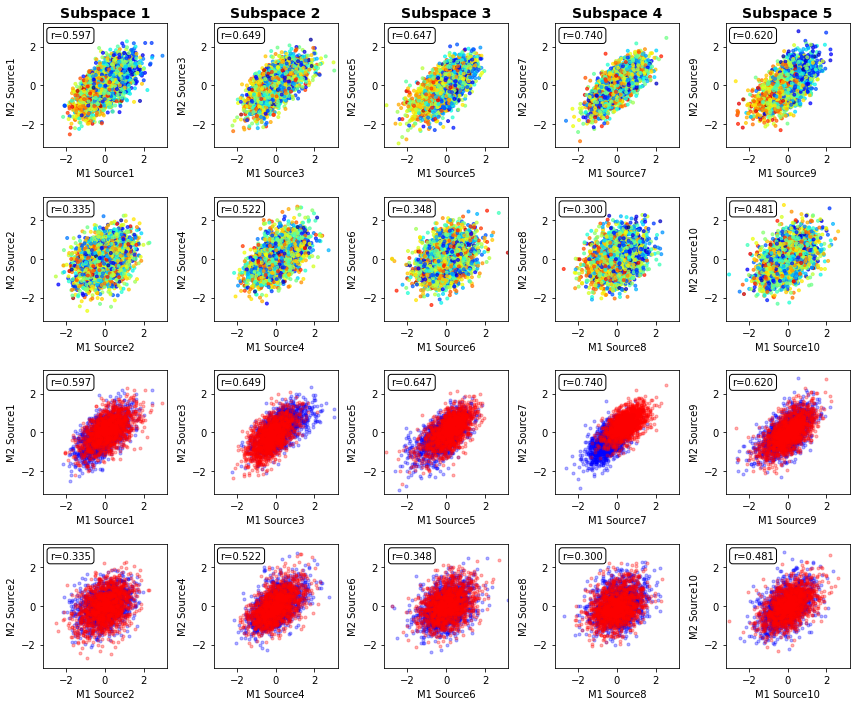

In [8]:
cols = plt.cm.jet(np.linspace(0,1,round(max(age)-min(age)+1)))

# CCA, color coded by age/sex
scv_list = []
for i in np.arange(0,10,2):
    scv_list.append([f"Source{i+1}", f"Source{i+2}"])

fig, axes = plt.subplots(4,5,figsize=(12,10))

for k in range(5):
    for i in range(2):
        WAY1 = WAY_list[k][0]
        WAY2 = WAY_list[k][1]

        sign1 = np.sign(correlation(WAY1,age))
        sign2 = np.sign(correlation(WAY2,age))
        for j in range(2):
            WAY1[j,:] = -sign1[j]*WAY1[j,:]
            WAY2[j,:] = -sign2[j]*WAY2[j,:]

        axes[i+2,k].plot(WAY1[i][sex==0], WAY2[i][sex==0],'b.',alpha=0.3)
        axes[i+2,k].plot(WAY1[i][sex==1], WAY2[i][sex==1],'r.',alpha=0.3)
        axes[i,k].set_aspect('equal', 'box')
        axes[i,k].set_xlabel(f'M1 {scv_list[k][i]}')
        axes[i,k].set_ylabel(f'M2 {scv_list[k][i]}')
        axes[i,k].set_xlim([-3.2,3.2])
        axes[i,k].set_ylim([-3.2,3.2])
        r = format(round(cca_corr_list[k][i,i],3), '.3f')
        axes[i,k].annotate(f'r={r}', xy=(48, 117), xycoords='axes points',
            size=10, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))

        col = np.zeros((len(age),4))
        for n in range(len(age)):
            colorind = round(age[n]-min(age))
            col[n] = cols[colorind]
        axes[i,k].scatter(WAY1[i], WAY2[i], color=col, marker='.', alpha=0.7)
        axes[i+2,k].set_aspect('equal', 'box')
        axes[i+2,k].set_xlabel(f'M1 {scv_list[k][i]}')
        axes[i+2,k].set_ylabel(f'M2 {scv_list[k][i]}')
        axes[i+2,k].set_xlim([-3.2,3.2])
        axes[i+2,k].set_ylim([-3.2,3.2])
        axes[i+2,k].annotate(f'r={r}', xy=(48, 117), xycoords='axes points',
            size=10, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))

        if i == 0:
            axes[i,k].set_title(f"Subspace {k+1}", fontsize=14, fontweight="bold")

plt.tight_layout()
# plt.savefig("cca_age_sex.pdf")
# plt.savefig("cca_age_sex.png", dpi=500)

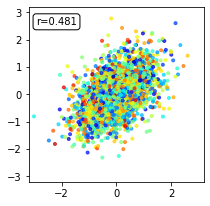

In [11]:
k=4
i=1

WAY1 = WAY_list[k][0]
WAY2 = WAY_list[k][1]

sign1 = np.sign(correlation(WAY1,age))
sign2 = np.sign(correlation(WAY2,age))
for j in range(2):
    WAY1[j,:] = -sign1[j]*WAY1[j,:]
    WAY2[j,:] = -sign2[j]*WAY2[j,:]

r = format(round(cca_corr_list[k][i,i],3), '.3f')

col = np.zeros((len(age),4))
for n in range(len(age)):
    colorind = round(age[n]-min(age))
    col[n] = cols[colorind]

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(WAY1[i], WAY2[i], color=col, marker='.', alpha=0.7)
ax.set_aspect('equal', 'box')
ax.set_xlim([-3.2,3.2])
ax.set_ylim([-3.2,3.2])
ax.annotate(f'r={r}', xy=(48, 165), xycoords='axes points',
    size=10, ha='right', va='top',
    bbox=dict(boxstyle='round', fc='w'))

plt.tight_layout()
plt.savefig("cca_age_sex_ukb_sign_adjusted_age_subspace5_source10.png",dpi=500)

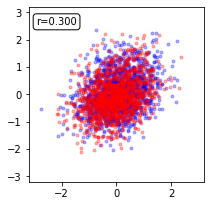

In [15]:
k=3
i=1

WAY1 = WAY_list[k][0]
WAY2 = WAY_list[k][1]

sign1 = np.sign(correlation(WAY1,age))
sign2 = np.sign(correlation(WAY2,age))
for j in range(2):
    WAY1[j,:] = -sign1[j]*WAY1[j,:]
    WAY2[j,:] = -sign2[j]*WAY2[j,:]

r = format(round(cca_corr_list[k][i,i],3), '.3f')

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(WAY1[i][sex==0], WAY2[i][sex==0],'b.',alpha=0.3)
ax.plot(WAY1[i][sex==1], WAY2[i][sex==1],'r.',alpha=0.3)
ax.set_aspect('equal', 'box')
ax.set_xlim([-3.2,3.2])
ax.set_ylim([-3.2,3.2])
ax.annotate(f'r={r}', xy=(48, 165), xycoords='axes points',
    size=10, ha='right', va='top',
    bbox=dict(boxstyle='round', fc='w'))

plt.tight_layout()
plt.savefig("cca_age_sex_ukb_sign_adjusted_sex_subspace4_source8.png",dpi=500)

In [34]:
WAY = WAY_list[3]
WAY1 = WAY[0]
WAY2 = WAY[1]

A1_ = (np.linalg.inv(WAY1 @ WAY1.T) @ (WAY1 @ AY1.T)).T
AY1_ = np.expand_dims(A1_[:,0], axis=1) @ np.expand_dims(WAY1[0,:], axis=0)
AY1_male = np.expand_dims(A1_[:,0], axis=1) @ np.expand_dims(WAY1[0,:][sex==0], axis=0)
AY1_female = np.expand_dims(A1_[:,0], axis=1) @ np.expand_dims(WAY1[0,:][sex==1], axis=0)
A1_.shape, AY1_.shape, AY1_male.shape, AY1_female.shape

((44318, 2), (44318, 2907), (44318, 1452), (44318, 1455))

In [35]:
# TODO plot 3D volume, also for source 3
spatial_map_male = np.mean(AY1_male, axis=1)
spatial_map_female = np.mean(AY1_female, axis=1)

In [37]:
sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/CCA_subspace4_source7_male.mat", {"A":spatial_map_male})
sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/CCA_subspace4_source7_female.mat", {"A":spatial_map_female})

In [21]:
A_ = np.zeros( (2, 10, 44318) ) #2 modalities, 10 sources, 44318 voxels

for j, i in enumerate(np.arange(0,10,2)):
# for j, i in enumerate([0]):
    # S1-4, UA/MSIVA/GICA, M1-2, voxel, source
    A1 = A[1,1,0,:,i:i+2] # structure 2, MSIVA, M1, subspace 1
    A2 = A[1,1,1,:,i:i+2] # structure 2, MSIVA, M2, subspace 1

    Y1 = Y[1,1,0,i:i+2] 
    Y2 = Y[1,1,1,i:i+2] 

    AY1 = A1@Y1
    AY2 = A2@Y2

    WAY1 = WAY_list[j][0]
    WAY2 = WAY_list[j][1]

    sign1 = np.sign(correlation(WAY1,age))
    sign2 = np.sign(correlation(WAY2,age))
    for j in range(2):
        WAY1[j,:] = -sign1[j]*WAY1[j,:]
        WAY2[j,:] = -sign2[j]*WAY2[j,:]
        # print(np.sign(correlation(WAY1[j,:],age)))
        # print(np.sign(correlation(WAY2[j,:],age)))
    
    A1_ = (np.linalg.inv(WAY1 @ WAY1.T) @ (WAY1 @ AY1.T)).T
    A2_ = (np.linalg.inv(WAY2 @ WAY2.T) @ (WAY2 @ AY2.T)).T

    A_[0,i] = A1_[:,0]
    A_[1,i] = A2_[:,0]

    A_[0,i+1] = A1_[:,1]
    A_[1,i+1] = A2_[:,1]

sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/CCA_A_10scv_correct.mat", {"A":A_})

In [107]:
def age_regression(X_train, X_test, y_train, y_test, a = 1):
    clf = Ridge(alpha=a) 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mae = np.mean(np.abs(y_pred-y_test))
    return mae

def sex_classification(X_train, X_test, y_train, y_test, c=1):
    clf = SVC(kernel='linear',C=c)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = 1 - np.mean(np.abs(y_pred-y_test))
    return acc

In [109]:
regularizer_range = np.linspace(0.1, 1, 10)
param_grid_rr = [{'alpha': regularizer_range}]
param_grid_svm = [{'C': regularizer_range}]
param_grid_svm

[{'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

In [110]:
for i in range(5):
    
    X12 = (np.concatenate( (WAY_list[i][0], WAY_list[i][1]), axis=0 )).T

    X_train, X_test, y_train, y_test = train_test_split(X12, age, test_size=0.312, random_state=42)
    base_estimator = Ridge()
    rr = GridSearchCV(base_estimator, param_grid_rr, cv=10).fit(X_train, y_train)
    mae = age_regression(X_train, X_test, y_train, y_test, a=rr.best_params_['alpha'])

    X_train, X_test, y_train, y_test = train_test_split(X12, sex, test_size=0.312, random_state=42)
    base_estimator = SVC()
    svc = GridSearchCV(base_estimator, param_grid_svm, cv=10).fit(X_train, y_train)
    acc = sex_classification(X_train, X_test, y_train, y_test, c=svc.best_params_['C'])

    print(f"Subspace {i+1}, Age Regression MAE {round(mae, 4)}, Sex Classification Accuracy {round(acc, 4)}")

Subspace 1, Age Regression MAE 5.7565, Sex Classification Accuracy 0.5943
Subspace 2, Age Regression MAE 6.27, Sex Classification Accuracy 0.6097
Subspace 3, Age Regression MAE 5.9359, Sex Classification Accuracy 0.5755
Subspace 4, Age Regression MAE 5.8876, Sex Classification Accuracy 0.8115
Subspace 5, Age Regression MAE 5.4002, Sex Classification Accuracy 0.5303


In [98]:
for i in range(5):
    for j in range(2):
        X12 = (np.concatenate( (np.expand_dims(WAY_list[i][0][j], axis=0), np.expand_dims(WAY_list[i][1][j], axis=0)), axis=0 )).T

        X_train, X_test, y_train, y_test = train_test_split(X12, age, test_size=0.312, random_state=42)
        mae = age_regression(X_train, X_test, y_train, y_test)

        X_train, X_test, y_train, y_test = train_test_split(X12, sex, test_size=0.312, random_state=42)
        acc = sex_classification(X_train, X_test, y_train, y_test)

        print(f"SCV {2*i+j+1}, Age Regression MAE {round(mae, 4)}, Sex Classification Accuracy {round(acc, 4)}")

SCV 1, Age Regression MAE 5.7572, Sex Classification Accuracy 0.5932
SCV 2, Age Regression MAE 6.2872, Sex Classification Accuracy 0.4928
SCV 3, Age Regression MAE 6.2664, Sex Classification Accuracy 0.6141
SCV 4, Age Regression MAE 6.2862, Sex Classification Accuracy 0.4928
SCV 5, Age Regression MAE 5.9387, Sex Classification Accuracy 0.5733
SCV 6, Age Regression MAE 6.2826, Sex Classification Accuracy 0.5072
SCV 7, Age Regression MAE 6.2623, Sex Classification Accuracy 0.8148
SCV 8, Age Regression MAE 5.9093, Sex Classification Accuracy 0.5237
SCV 9, Age Regression MAE 5.4045, Sex Classification Accuracy 0.5017
SCV 10, Age Regression MAE 6.281, Sex Classification Accuracy 0.5226


In [136]:
predictor = np.concatenate((np.expand_dims(age,axis=1),np.expand_dims(sex,axis=1)), axis=1)
response = []
for i in range(2): # modality
    for j in range(5): # subspace
        for k in range(2): # source in each subspace
            response.append(WAY_list[j][i][k])
response = np.array(response).T

In [140]:
data = np.concatenate((predictor, response), axis=1)

data_name = ['Age', 'Sex']
for i in range(2):
    for j in range(10):
        data_name.append(f'M{i+1}SCV{j+1}')

df = pd.DataFrame(data, columns=data_name)
df.head(5)

,Age,Sex,M1SCV1,M1SCV2,M1SCV3,M1SCV4,M1SCV5,M1SCV6,M1SCV7,M1SCV8,...,M2SCV1,M2SCV2,M2SCV3,M2SCV4,M2SCV5,M2SCV6,M2SCV7,M2SCV8,M2SCV9,M2SCV10
0,52.0,1.0,0.095289,-0.289919,1.577211,0.025259,0.432985,-0.105089,0.452089,0.458566,...,0.599969,-1.439754,1.768398,0.746909,-0.806290,-0.228013,0.505640,-0.131070,-0.338222,0.287661
1,58.0,0.0,-0.209279,1.564589,-1.514870,1.343126,-0.320308,-0.729529,0.165923,0.390572,...,0.016566,1.549646,-0.296889,0.282042,0.264495,-1.365169,-0.202607,1.152755,0.656027,-0.284636
2,63.0,1.0,-0.019074,0.841844,0.668745,-0.517125,0.306222,0.659172,1.204556,-1.285234,...,-0.781587,-0.414042,0.809663,1.433106,0.081417,-1.084909,-0.093963,-0.886406,-0.821991,-0.904209
3,68.0,1.0,-0.003659,0.456106,-0.143684,0.919356,0.666887,-0.730645,-0.134193,1.275913,...,-0.134692,-0.344382,-0.144625,0.574913,0.456076,0.500038,-0.713306,0.421774,-0.287226,-1.151311
4,67.0,1.0,1.514203,0.808760,0.491031,-0.322971,-0.057218,0.952883,0.552190,0.824258,...,0.413265,0.977154,0.115063,-0.638534,-0.269157,0.037212,0.418436,0.308889,-1.837294,-0.047254


In [141]:
# evaluate first subspace 
fit = MANOVA.from_formula('M1SCV1 + M1SCV2 + M2SCV1 + M2SCV2 ~ Age + Sex', data=df)
print(fit.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF   Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8986 4.0000 2901.0000 81.8224 0.0000
         Pillai's trace 0.1014 4.0000 2901.0000 81.8224 0.0000
 Hotelling-Lawley trace 0.1128 4.0000 2901.0000 81.8224 0.0000
    Roy's greatest root 0.1128 4.0000 2901.0000 81.8224 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          Age           Value  Num DF   Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8835 4.0000 2901.0000 95.5963 0.0000
         Pillai's trace 0.1165 4.0000 2901.0000 95.5963 0.0000
 Hotelling-

In [142]:
# evaluate second subspace 
fit = MANOVA.from_formula('M1SCV3 + M1SCV4 + M2SCV3 + M2SCV4 ~ Age + Sex', data=df)
print(fit.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF   Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9789 4.0000 2901.0000 15.6464 0.0000
         Pillai's trace 0.0211 4.0000 2901.0000 15.6464 0.0000
 Hotelling-Lawley trace 0.0216 4.0000 2901.0000 15.6464 0.0000
    Roy's greatest root 0.0216 4.0000 2901.0000 15.6464 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          Age           Value  Num DF   Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9882 4.0000 2901.0000  8.6698 0.0000
         Pillai's trace 0.0118 4.0000 2901.0000  8.6698 0.0000
 Hotelling-

In [143]:
# evaluate third subspace 
fit = MANOVA.from_formula('M1SCV5 + M1SCV6 + M2SCV5 + M2SCV6 ~ Age + Sex', data=df)
print(fit.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF   Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9321 4.0000 2901.0000 52.8295 0.0000
         Pillai's trace 0.0679 4.0000 2901.0000 52.8295 0.0000
 Hotelling-Lawley trace 0.0728 4.0000 2901.0000 52.8295 0.0000
    Roy's greatest root 0.0728 4.0000 2901.0000 52.8295 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          Age           Value  Num DF   Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9189 4.0000 2901.0000 64.0141 0.0000
         Pillai's trace 0.0811 4.0000 2901.0000 64.0141 0.0000
 Hotelling-

In [144]:
# evaluate forth subspace 
fit = MANOVA.from_formula('M1SCV7 + M1SCV8 + M2SCV7 + M2SCV8 ~ Age + Sex', data=df)
print(fit.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
        Intercept        Value  Num DF   Den DF  F Value Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.8859 4.0000 2901.0000 93.4038 0.0000
          Pillai's trace 0.1141 4.0000 2901.0000 93.4038 0.0000
  Hotelling-Lawley trace 0.1288 4.0000 2901.0000 93.4038 0.0000
     Roy's greatest root 0.1288 4.0000 2901.0000 93.4038 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
           Age           Value  Num DF   Den DF  F Value Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.9044 4.0000 2901.0000 76.6217 0.0000
          Pillai's trace 0.0956 4.0000 2901.0000 76.6217 0.

In [145]:
# evaluate fifth subspace 
fit = MANOVA.from_formula('M1SCV9 + M1SCV10 + M2SCV9 + M2SCV10 ~ Age + Sex', data=df)
print(fit.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value  Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.8035 4.0000 2901.0000 177.3957 0.0000
         Pillai's trace 0.1965 4.0000 2901.0000 177.3957 0.0000
 Hotelling-Lawley trace 0.2446 4.0000 2901.0000 177.3957 0.0000
    Roy's greatest root 0.2446 4.0000 2901.0000 177.3957 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
          Age           Value  Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.7960 4.0000 2901.0000 185.8606 0.0000
         Pillai's trace 0.2040 4.0000 2901.0000 185.8606 0.

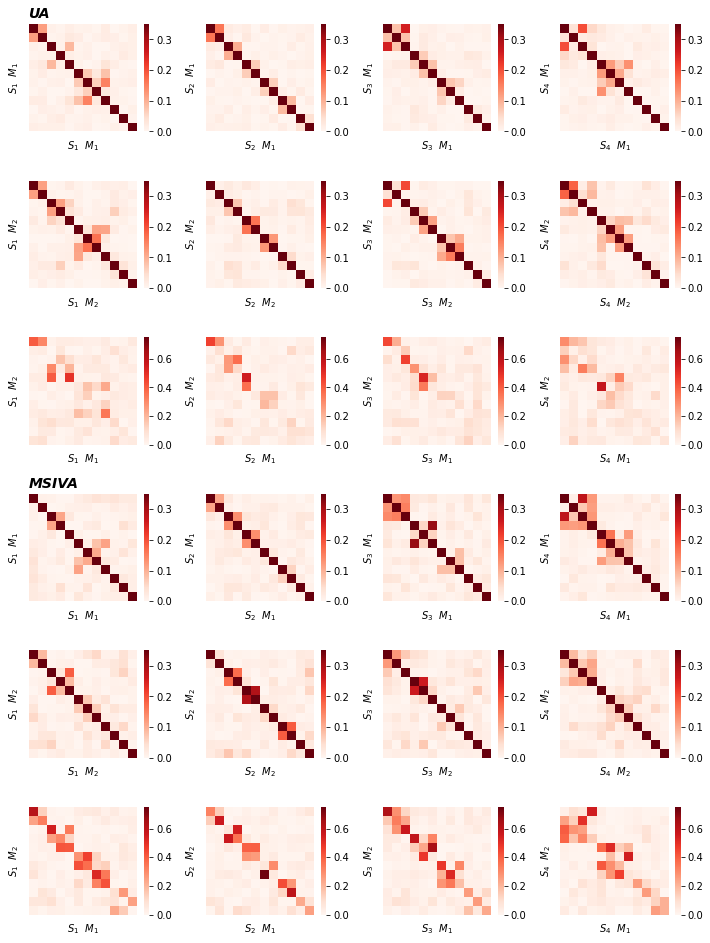

In [130]:
# cmap_list=["YlGn","YlGn","Purples","Purples"]
analysis_list = ["UA"]*3+["MSIVA"]*3

fig,axes=plt.subplots(6,4,figsize=(10,2.2*6))

for i in range(4):
    for j in range(6):
        if j == 2 or j == 5:
            sns.heatmap(np.abs(corr[i,j]),cmap="Reds",vmin=0,vmax=0.75,ax=axes[j,i])#Purples
            axes[j,i].set_xlabel(f"$S_{i+1}$  $M_1$")
            axes[j,i].set_ylabel(f"$S_{i+1}$  $M_2$")
            # axes[j,i].set_title(f"$S_{i+1}$  $M_1$ vs $M_2$")
            # axes[j,i].set_title(f"{analysis_list[j]}  $S_{i+1}$  $M_1$ vs $M_2$")#cross-correlation
        else:
            sns.heatmap(np.abs(corr[i,j]),cmap="Reds",vmin=0,vmax=0.35,ax=axes[j,i])#Purples
            axes[j,i].set_xlabel(f"$S_{i+1}$  $M_{j%3+1}$")
            axes[j,i].set_ylabel(f"$S_{i+1}$  $M_{j%3+1}$")
            # axes[j,i].set_title(f"$~~S_{i+1}$  $M_{j%3+1}$")
            # axes[j,i].set_title(f"{analysis_list[j]}  $S_{i+1}$  $M_{j%3+1}$")#self-correlation($Y$)
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        # axes[j,i].set_axis_off()
        if i == 0 and j == 0:
            axes[j][i].set_title("UA", loc="left", fontsize=14, fontstyle="italic", fontweight="bold")
        if i == 0 and j == 3:
            axes[j][i].set_title("MSIVA", loc="left", fontsize=14, fontstyle="italic", fontweight="bold")

plt.tight_layout()
# plt.savefig("neuroimaging.png",dpi=300)
plt.savefig("neuroimaging_red.pdf")

In [4]:
num_iter=21
loss_um=np.zeros((4,num_iter))
loss_ummm=np.zeros((4,num_iter))

for i,ss in enumerate(subspace_struct_list):
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging.mat"))
    a = np.squeeze(data['aux_um'][1,:])
    loss_um[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging.mat"))
    a = np.squeeze(data['aux_ummm'][1,:])
    loss_ummm[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

In [7]:
isi_um_min = np.min(loss_um,axis=1)
isi_ummm_min = np.min(loss_ummm,axis=1)
print(np.argmin(isi_um_min))
print(np.argmin(isi_ummm_min))
print(isi_um_min)
print(isi_ummm_min)

0
1
[47.73528799 47.81060931 47.76835435 47.77763907]
[46.79423777 46.77480401 46.79766108 46.89191746]


In [6]:
Xpath="/Users/xli77/Documents/MISA/MISA-data/sMRI-fMRI/X.mat"
X=sio.loadmat(Xpath)['X']
X=np.squeeze(X)

In [7]:
maskpath="/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/gmMask_TPM_thrp2_fractc8_3mm.nii"
maskfile=nib.load(maskpath)
mask_affine = maskfile.affine
mask=maskfile.get_fdata()
# sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/gmMask_TPM_thrp2_fractc8_3mm.mat", {"mask":mask})

In [ ]:
t1path="/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/MNI152_T1_3mm_brain.nii.gz"
t1file=nib.load(t1path)
template=t1file.get_fdata()
sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/MNI152_T1_3mm_brain.mat", {"MNI152T1Template":template})

In [10]:
A = np.zeros((4,2,2,X[0].shape[0],12)) # S1-4, UA/MSIVA, M1-2, voxel, source
for i,ss in enumerate(subspace_struct_list):
    for j,a in enumerate(["um","ummm"]):
        for k,m in enumerate([0,1]):
            data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}",f"{a}_neuroimaging_Y.mat"))
            Y=np.squeeze(data[f'Y{j+1}'])[k]
            At = np.linalg.inv(Y @ Y.T) @ (Y @ X[k].T)
            A[i,j,k] = At.T
# sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/A.mat", {"A":A})

In [8]:
vol=sio.loadmat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/vol3d.mat")['vol3d']
vol.shape

(4, 2, 2, 12, 61, 73, 61)

In [8]:
cca_vol=sio.loadmat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/CCA_vol3d.mat")['vol3d']
cca_vol.shape

(2, 5, 61, 73, 61)

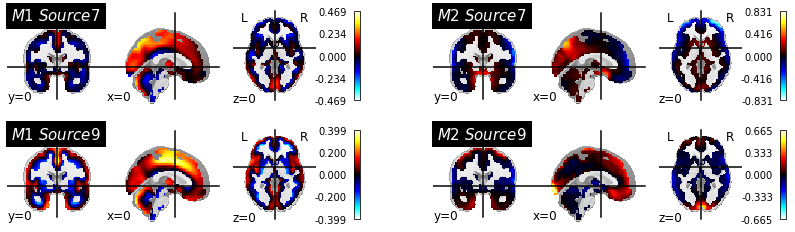

In [33]:
num_rows = 2
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(14,4))

for i in range(num_rows):
    for j in range(num_cols):
        v = cca_vol[j,i+3]
        img = nib.Nifti1Image(v,maskfile.affine)
        plotting.plot_stat_map(img,title=f"$M{j+1}$ $Source{2*i+7}$",colorbar=True,cut_coords=(0,0,0),cbar_tick_format='%.3f',axes=axes[i,j])
# plt.tight_layout()
fig.savefig(f'cca_stat_map_xyz000_label_source7-9.pdf', bbox_inches = 'tight', pad_inches = 0)

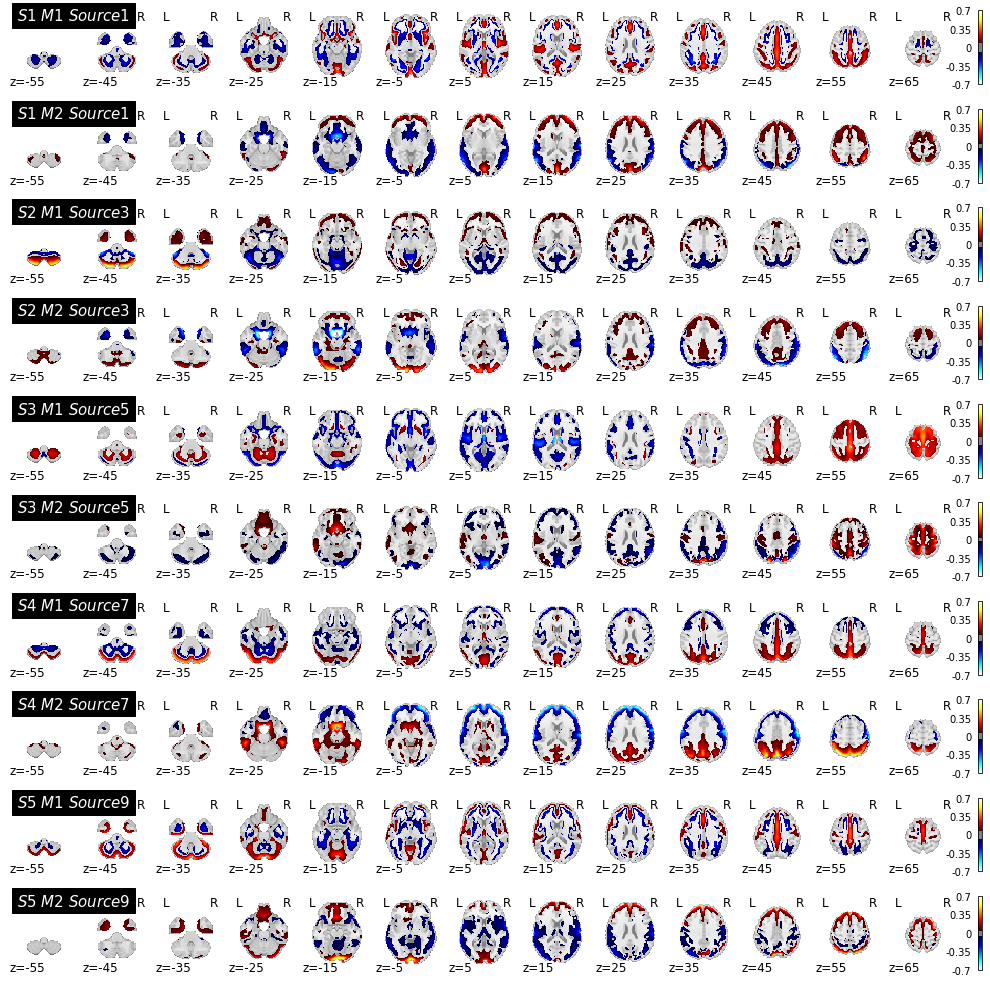

In [42]:
num_rows = 10
num_cols = 1

fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(num_cols*17.5,num_rows*1.78))

for i in range(num_rows//2):
    for j in range(2):
        v = cca_vol[j,i]
        v_masked = v.flatten()[np.where(mask.flatten() != 0)[0]]
        img = nib.Nifti1Image(v, mask_affine)
        plotting.plot_stat_map(img, title=f"$S{i+1}$ $M{j+1}$ $Source{2*i+1}$", display_mode="z", cut_coords=np.arange(-55,66,10), colorbar=True, vmax=np.max(cca_vol), threshold=np.max(np.abs([np.percentile(v_masked, [75, 25])])), axes=axes[2*i+j])
        # plotting.plot_stat_map(img,title=f"$M{j+1}$ $Source{2*i+7}$",colorbar=True,cut_coords=np.arange(-60,76,15),cbar_tick_format='%.3f',axes=axes[i,j])
fig.savefig(f'cca_stat_map_xyz000_label_axial_thrmax.pdf', bbox_inches = 'tight', pad_inches = 0)

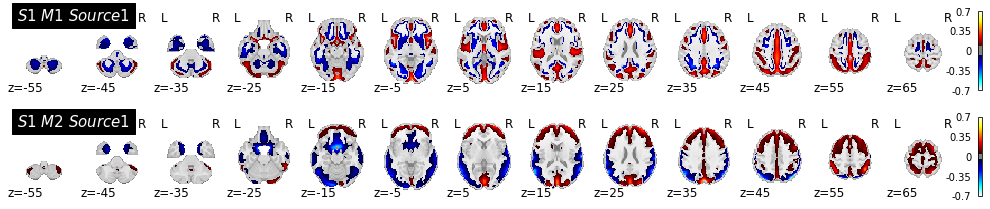

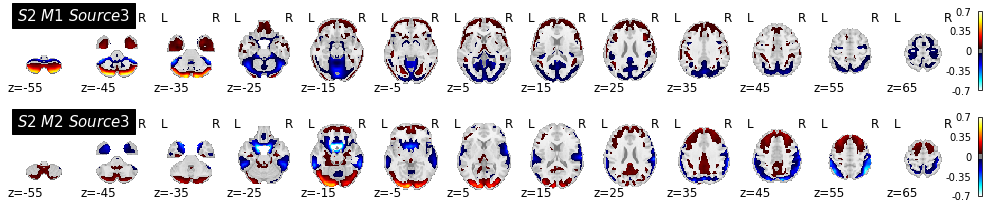

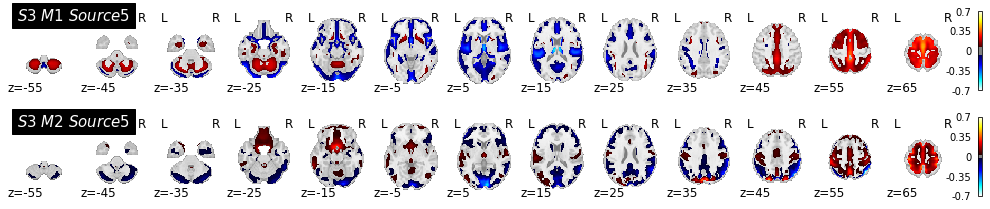

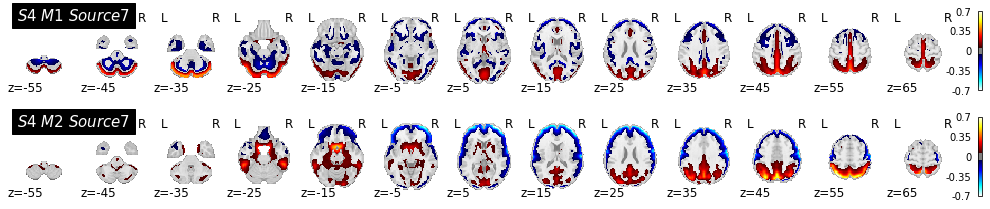

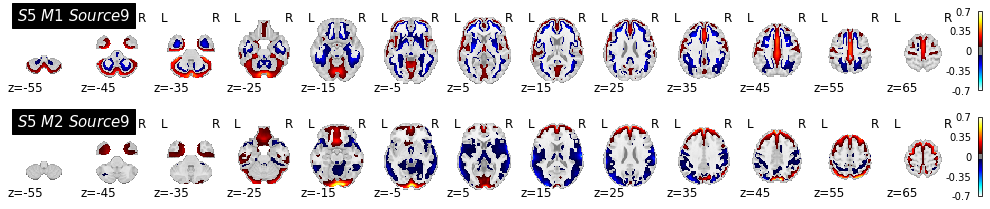

In [41]:
num_rows = 2
num_cols = 1

for i in range(5):
    fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(num_cols*17.5,num_rows*1.78))
    for j in range(2):
        v = cca_vol[j,i]
        v_masked = v.flatten()[np.where(mask.flatten() != 0)[0]]
        img = nib.Nifti1Image(v, mask_affine)
        plotting.plot_stat_map(img, title=f"$S{i+1}$ $M{j+1}$ $Source{2*i+1}$", display_mode="z", cut_coords=np.arange(-55,66,10), colorbar=True, vmax=np.max(cca_vol), threshold=np.max(np.abs([np.percentile(v_masked, [75, 25])])), axes=axes[j])
        # plotting.plot_stat_map(img,title=f"$M{j+1}$ $Source{2*i+7}$",colorbar=True,cut_coords=np.arange(-60,76,15),cbar_tick_format='%.3f',axes=axes[i,j])
    fig.savefig(f'cca_stat_map_xyz000_label_axial_S{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

/Users/xli77/miniconda3/envs/nhpseg/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


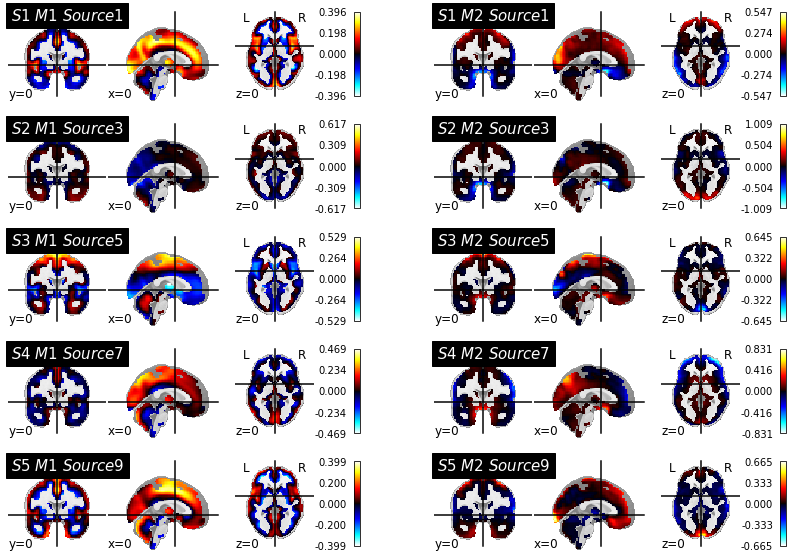

In [9]:
num_rows = 5
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(14,10))

for i in range(num_rows):
    for j in range(num_cols):
        v = cca_vol[j,i]
        img = nib.Nifti1Image(v,maskfile.affine)
        plotting.plot_stat_map(img,title=f"$S{i+1}$ $M{j+1}$ $Source{2*i+1}$",colorbar=True,cut_coords=(0,0,0),cbar_tick_format='%.3f',axes=axes[i,j])
        
# fig.savefig(f'cca_stat_map_xyz000_label.pdf', bbox_inches = 'tight', pad_inches = 0)
# fig.savefig(f'cca_stat_map_xyz000_label.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0)

/Users/xli77/miniconda3/envs/nhpseg/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


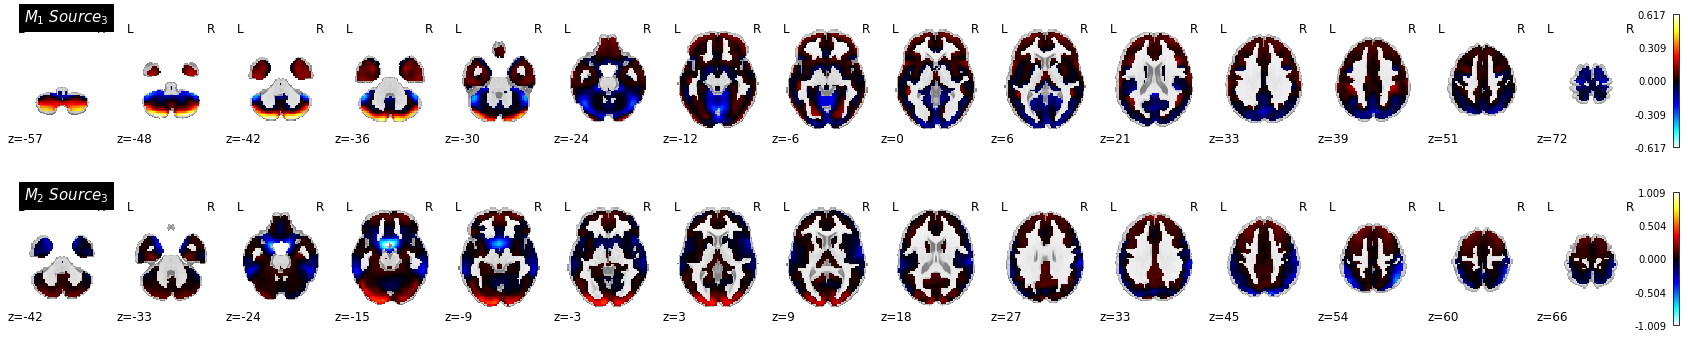

In [35]:
fig, ax = plt.subplots(2,1,figsize=(30,6))
v = cca_vol[0,1]
img = nib.Nifti1Image(v,maskfile.affine)
plotting.plot_stat_map(img,title=f"$M_1$ $Source_3$",colorbar=True,cbar_tick_format='%.3f',display_mode='z',cut_coords=15,axes=ax[0])

v = cca_vol[1,1]
img = nib.Nifti1Image(v,maskfile.affine)
plotting.plot_stat_map(img,title=f"$M_2$ $Source_3$",colorbar=True,cbar_tick_format='%.3f',display_mode='z',cut_coords=15,axes=ax[1])

fig.savefig(f'cca_stat_map_source3.pdf', bbox_inches = 'tight', pad_inches = 0)

In [1]:
# TODO
# vol_female=sio.loadmat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/CCA_subspace4_source7_female_vol3d.mat")['v3d']

# fig, ax = plt.subplots(1,1,figsize=(8,3))
# img = nib.Nifti1Image(vol_female,maskfile.affine)
# plotting.plot_stat_map(img,colorbar=True,cut_coords=(0,0,0),cbar_tick_format='%.3f',axes=axes[i,j])

# plt.tight_layout()
# fig.savefig(f'cca_stat_map_xyz000_label_source7-9.pdf', bbox_inches = 'tight', pad_inches = 0)

In [1]:
# wvol=sio.loadmat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/w3d.mat")['w3d']
# for i in range(12):
#     for j in range(2):
#         fig, ax = plt.subplots(1,1,figsize=(8,3))
#         img = nib.Nifti1Image(wvol[j,i],maskfile.affine)
#         plotting.plot_glass_brain(img,title=f"$S_1$ $M_{j+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',alpha=0.7,axes=ax)#axes=axes[i],
#         fig.savefig(f'W/UA_S1_M{j+1}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

In [7]:
# for i in range(12):
#     for j in range(4):
#         for k in range(2):
#             fig, ax = plt.subplots(1,1,figsize=(30,3))
#             v = vol[j,0,k,i]
#             img = nib.Nifti1Image(v,maskfile.affine)
#             plotting.plot_stat_map(img,title=f"$S_{j+1}$ $M_{k+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',display_mode='z',cut_coords=15,axes=ax)
#             fig.savefig(f'stat_map_axial/UA_S{j+1}_M{k+1}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

# for i in range(12):
#     for j in range(4):
#         for k in range(2):
#             fig, ax = plt.subplots(1,1,figsize=(30,3))
#             v = vol[j,1,k,i]
#             img = nib.Nifti1Image(v,maskfile.affine)
#             plotting.plot_stat_map(img,title=f"$S_{j+1}$ $M_{k+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',display_mode='z',cut_coords=15,axes=ax)
#             fig.savefig(f'stat_map_axial/MSIVA_S{j+1}_M{k+1}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

In [11]:
for i in range(12):
    for j in range(4):
        for k in range(2):
            fig, ax = plt.subplots(1,1,figsize=(8,3))
            img = nib.Nifti1Image(vol[j,0,k,i],maskfile.affine)
            plotting.plot_glass_brain(img,title=f"$S_{j+1}$ $M_{k+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',alpha=0.7,axes=ax)#axes=axes[i],
            fig.savefig(f'glass_brain/UA_S{j+1}_M{k+1}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

for i in range(12):
    for j in range(4):
        for k in range(2):
            fig, ax = plt.subplots(1,1,figsize=(8,3))
            img = nib.Nifti1Image(vol[j,1,k,i],maskfile.affine)
            plotting.plot_glass_brain(img,title=f"$S_{j+1}$ $M_{k+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',alpha=0.7,axes=ax)
            fig.savefig(f'glass_brain/MSIVA_S{j+1}_M{k+1}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

In [18]:
for i in range(12):
    for j in range(4):
        for k in range(2):
            fig, ax = plt.subplots(1,1,figsize=(8,3))
            v = vol[j,0,k,i]
            img = nib.Nifti1Image(v,maskfile.affine)
            plotting.plot_stat_map(img,title=f"$S_{j+1}$ $M_{k+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',axes=ax)
            fig.savefig(f'stat_map/UA_S{j+1}_M{k+1}_SCV{i+1}.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

for i in range(12):
    for j in range(4):
        for k in range(2):
            fig, ax = plt.subplots(1,1,figsize=(8,3))
            v = vol[j,1,k,i]
            img = nib.Nifti1Image(v,maskfile.affine)
            plotting.plot_stat_map(img,title=f"$S_{j+1}$ $M_{k+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',axes=ax)
            fig.savefig(f'stat_map/MSIVA_S{j+1}_M{k+1}_SCV{i+1}.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [8]:
for i in range(12):
    for j in range(4):
        for k in range(2):
            fig, ax = plt.subplots(1,1,figsize=(8,3))
            v = vol[j,0,k,i]
            img = nib.Nifti1Image(v,maskfile.affine)
            plotting.plot_stat_map(img,title=f"$S_{j+1}$ $M_{k+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',axes=ax)
            fig.savefig(f'stat_map/UA_S{j+1}_M{k+1}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

for i in range(12):
    for j in range(4):
        for k in range(2):
            fig, ax = plt.subplots(1,1,figsize=(8,3))
            v = vol[j,1,k,i]
            img = nib.Nifti1Image(v,maskfile.affine)
            plotting.plot_stat_map(img,title=f"$S_{j+1}$ $M_{k+1}$ $SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',axes=ax)
            fig.savefig(f'stat_map/MSIVA_S{j+1}_M{k+1}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

In [7]:
for i in range(4):
    for j in range(2):
        for k in ['UA','MSIVA']:
            merger = PdfFileMerger()
            # pdf_files = glob.glob(f'glass_brain/{k}_S{i+1}_M{j+1}_SCV*')
            # pdf_files = glob.glob(f'stat_map_axial/{k}_S{i+1}_M{j+1}_SCV*')
            pdf_files = glob.glob(f'stat_map_axial/{k}_S{i+1}_M{j+1}_SCV*')
            sorted_pdf_files = natsorted(pdf_files)
            
            for pdf_file in sorted_pdf_files:
                merger.append(pdf_file)
            # merger.write(f'glass_brain_{k}_S{i+1}_M{j+1}_SCV.pdf')
            merger.write(f'stat_map_axial_{k}_S{i+1}_M{j+1}_SCV.pdf')
            merger.close()